# Predicting Shortable Stocks

### BUSI 722: Data-Driven Finance II
### Kerry Back, Rice University

### Outline

1. Build feature dataset with today's features
2. Go to Alpaca to see which stocks are shortable
3. Use RandomForestClassifier with GridSearchCV to predict whether a stock is shortable based on volume and marketcap
4. Save the model

In [65]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from joblib import load 
import yfinance as yf 
from datetime import datetime
import os.path

from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest, GetAssetsRequest, AssetClass
from alpaca.trading.enums import OrderSide, TimeInForce

### Build Feature Dataset

- Don't need much history.  Start here in 2022.
- And don't need weekly returns (after computing momentum).

In [66]:
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver = 'SQL+Server'
string = f"mssql+pyodbc://{username}:{password}@{server}/{database}" 
try: 
    conn = create_engine(string + "?driver='SQL+Server'").connect()
except:
    try:
        conn = create_engine(string + "?driver='ODBC+Driver+18+for+SQL+Server'").connect()
    except:
        import pymssql
        string = f"mssql+pymssql://{username}:{password}@{server}/{database}"   
        conn = create_engine(string).connect() 

In [67]:
sep_weekly = pd.read_sql(
    """ 
    select date, ticker, closeadj, closeunadj, volume, lastupdated from sep_weekly 
    where date >= '2022-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
sep_weekly = sep_weekly.groupby(["ticker", "date"]).last()
sep_weekly = sep_weekly.drop(columns=["lastupdated"])

ret = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change()
ret.name = "ret"

price = sep_weekly.closeunadj
price.name = "price"

volume = sep_weekly.volume 
volume.name = "volume"

In [68]:
ret_annual = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(52)
ret_monthly = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(4)
mom = (1 + ret_annual) / (1 + ret_monthly) - 1
mom.name = "mom"

In [69]:
weekly = pd.read_sql(
    """ 
    select date, ticker, pb, marketcap, lastupdated from weekly 
    where date>='2022-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
weekly = weekly.groupby(["ticker", "date"]).last()
weekly = weekly.drop(columns=["lastupdated"])

pb = weekly.pb
pb.name = "pb" 
marketcap = weekly.marketcap 
marketcap.name = "marketcap"

In [70]:
sf1 = pd.read_sql(
    """ 
    select datekey as date, ticker, assets, netinc, equity, lastupdated from sf1
    where datekey>='2022-01-01' and dimension='ARY' and assets>0 and equity>0
    order by ticker, datekey, lastupdated    
    """,
    conn,
)
sf1 = sf1.groupby(["ticker", "date"]).last()
sf1 = sf1.drop(columns=["lastupdated"])

# change dates to Fridays
from datetime import timedelta 
sf1 = sf1.reset_index()
sf1.date =sf1.date.map(
    lambda x: x + timedelta(4 - x.weekday())
)
sf1 = sf1.set_index(["ticker", "date"])
sf1 = sf1[~sf1.index.duplicated()]

assets = sf1.assets
assets.name = "assets" 
netinc = sf1.netinc 
netinc.name = "netinc" 
equity = sf1.equity
equity.name = "equity"

equity = equity.groupby("ticker", group_keys=False).shift() 
roe = netinc / equity 
roe.name = "roe"

assetgr = assets.groupby("ticker", group_keys=False).pct_change()
assetgr.name = "assetgr"

In [71]:
df = pd.concat(
    (
        mom, 
        volume,
        price, 
        pb, 
        marketcap, 
        roe, 
        assetgr
        ), 
        axis=1
    )
df["roe"] = df.groupby("ticker", group_keys=False).roe.ffill()
df["assetgr"] = df.groupby("ticker", group_keys=False).assetgr.ffill()

df = df.reset_index()
df.date = df.date.astype(str)
df = df[df.date==df.date.max()]
df = df[df.price >= 5]
df = df.dropna()

features = [
    "mom",
    "volume",
    "pb",
    "marketcap",
    "roe",
    "assetgr" 
]

In [72]:
industries = pd.read_sql(
    """ 
    select ticker, famaindustry as industry from tickers   
    """,
    conn,
)
industries["industry"] = industries.industry.fillna("Almost Nothing")
df = df.merge(industries, on="ticker", how="left")
df = df.dropna()

In [73]:
for x in features:
    df[f"{x}_industry"] = df.groupby(
        ["industry"], 
        group_keys=False
    )[x].apply(
        lambda x: x - x.median()
    )

features += [f"{x}_industry" for x in features]

In [74]:
for f in features:
    df[f] = df[f].rank(pct=True)

### Predicting shortable

In [75]:
with open("keys.txt", "r") as f:
    keys = f.readlines()

key, secret_key = [x.strip() for x in keys]
trading_client = TradingClient(key, secret_key, paper=True)

search_params = GetAssetsRequest(asset_class=AssetClass.US_EQUITY)
assets = trading_client.get_all_assets(search_params)
not_shortable = [x.symbol for x in assets if not x.shortable]
df["not_shortable"] = df.ticker.isin(not_shortable)

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_curve,
    RocCurveDisplay
)
from sklearn.model_selection import train_test_split, GridSearchCV

rcf = RandomForestClassifier(class_weight="balanced")
param_grid = {"max_depth": range(2, 22, 2)}

cv = GridSearchCV(
    rcf,
    param_grid = param_grid
)

train, test = train_test_split(df, test_size=0.2)
X_train = train[["volume", "marketcap"]].to_numpy()
X_test = test[["volume", "marketcap"]].to_numpy()
y_train = train["not_shortable"].to_numpy() 
y_test = test["not_shortable"].to_numpy()

cv.fit(X_train, y_train)
print(f"best max_depth is {cv.best_params_['max_depth']}")

best max_depth is 20


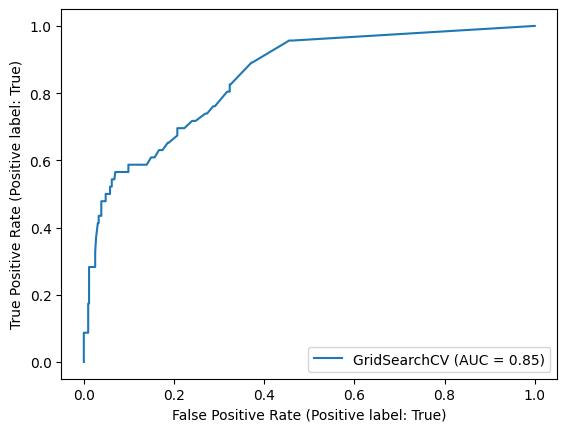

In [77]:
RocCurveDisplay.from_estimator(
    estimator=cv, 
    X=X_test, 
    y=y_test
)

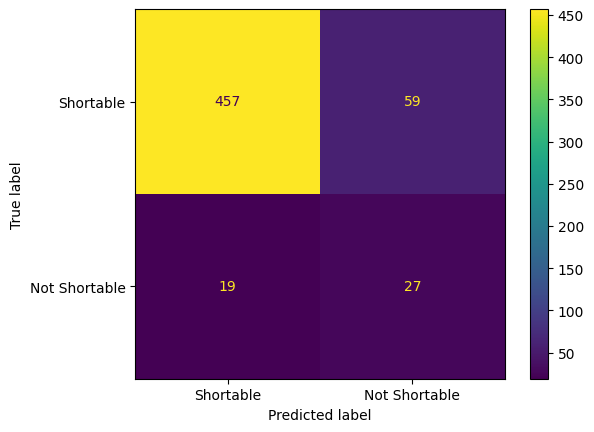

In [78]:
threshold_prob = 0.15

prob = cv.predict_proba(X_test)[:, 1]
predict = 1 * (prob > threshold_prob) 
cm = confusion_matrix(1 * y_test, predict)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Shortable", "Not Shortable"])
cmd.plot()

In [79]:
from joblib import dump 
dump(cv.best_estimator_, "not_shortable.joblib")

['not_shortable.joblib']